# AB browser test

В данном задании нужно будет:
* проанализировать АБ тест, проведённый на реальных пользователях Яндекса;
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами;
* определить характер этих изменений и практическую значимость вводимого изменения;
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

Описание данных:
* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data=pd.read_csv('ab_browser_test.csv')

In [5]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [10]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.


In [27]:
#количество кликов в группе exp
n_clicks_in_exp=data[data.slot=='exp'].n_clicks.sum()
print'Number of clicks in exp group: ',n_clicks_in_exp

Number of clicks in exp group:  3261823


In [28]:
#количество кликов в группе control
n_clicks_in_control=data[data.slot=='control'].n_clicks.sum()
print'Number of clicks in control group: ',n_clicks_in_control

Number of clicks in control group:  3210027


In [42]:
#подсчитаем разницу в процентах
proportion_in_clicks=(float(n_clicks_in_exp) / n_clicks_in_control - 1)*100
print 'Proportion increase: %.3f%%'%proportion_in_clicks

Proportion increase: 1.614%


В группе exp на <span style="color:blue">1.614%</span> больше пользовательских кликов по сравнению с группой control от числа кликов в контрольной группе.

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. 

In [45]:
#подсчитаем среднее количества кликов
exp_clicks_mean=data[data.slot=='exp'].n_clicks.mean()
control_clicks_mean=data[data.slot=='control'].n_clicks.mean()
print 'Mean of clicks in exp group: %.4f'%exp_clicks_mean
print 'Mean of clicks in control group: %.4f'%control_clicks_mean

Mean of clicks in exp group: 11.5840
Mean of clicks in control group: 11.2809


In [47]:
#подсчитаем медианы кликов
exp_clicks_med=data[data.slot=='exp'].n_clicks.median()
control_clicks_med=data[data.slot=='control'].n_clicks.median()
print 'Median of clicks in exp group: ',exp_clicks_med
print 'Median of clicks in control group: ',control_clicks_med


Median of clicks in exp group:  5.0
Median of clicks in control group:  4.0


In [63]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [64]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [87]:
exp_clicks_values = data[data.slot == 'exp'].n_clicks.values
control_clicks_values = data[data.slot == 'control'].n_clicks.values


In [93]:
np.random.seed=0

exp_mean_scores = map(np.mean, get_bootstrap_samples(exp_clicks_values, 500))
control_mean_scores = map(np.mean, get_bootstrap_samples(control_clicks_values, 500))

print "95% confidence interval for the exp mean:",  stat_intervals(exp_mean_scores, 0.05)
print "95% confidence interval for the control mean:",  stat_intervals(control_mean_scores, 0.05)

exp_median_scores = map(np.median, get_bootstrap_samples(exp_clicks_values, 500))
control_median_scores = map(np.median, get_bootstrap_samples(control_clicks_values, 500))

print "95% confidence interval for the exp median:",  stat_intervals(exp_median_scores, 0.05)
print "95% confidence interval for the control median:",  stat_intervals(control_median_scores, 0.05)

95% confidence interval for the exp mean: [11.51308926 11.65155347]
95% confidence interval for the control mean: [11.21003166 11.36209032]
95% confidence interval for the exp median: [5. 5.]
95% confidence interval for the control median: [4. 4.]


In [95]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(control_median_scores, exp_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [1. 1.]


In [96]:
delta_mean_scores = map(lambda x: x[1] - x[0], zip(control_mean_scores, exp_mean_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between medians [0.20208661 0.40289022]


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

In [99]:
from matplotlib import pylab

In [101]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Arsl\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


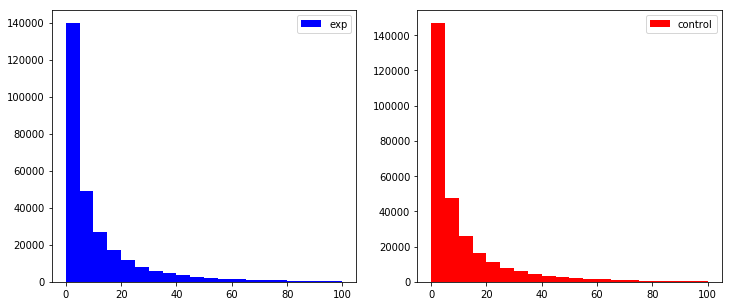

In [102]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.slot == 'exp'].n_clicks, bins = 20, color = 'b', range = (0, 100), label = 'exp')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.slot == 'control'].n_clicks, bins = 20, color = 'r', range = (0, 100), label = 'control')
pylab.legend()

pylab.show()

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* среднее значение в выборке было распределено нормально N(μ,σ2n)
* несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для этого

* получим из данных n_boot_samples псевдовыборок.
* по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего
* для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального распределения
* для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения 
`scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)` ,где sparams=(n-1) означают число степеней свободы = длине выборки - 1.





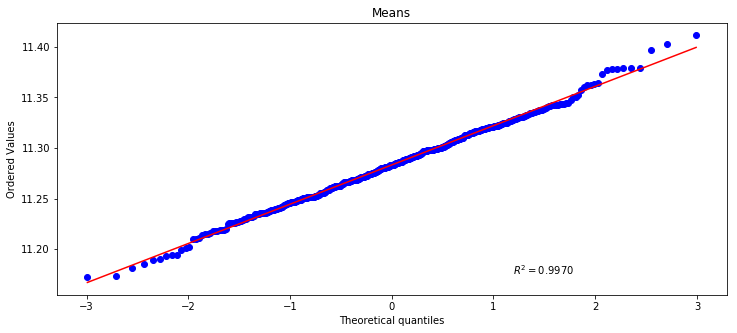

In [118]:
qq_mean=sts.probplot(control_mean_scores,plot=plt,rvalue=True)
qq_mean=plt.title('Means')

In [116]:
control_boot_chi_squared=map(np.std, get_bootstrap_samples(control_clicks_values, 500))


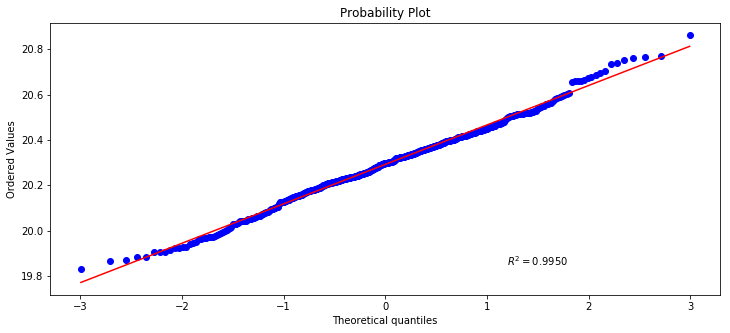

In [117]:
qq_std=sts.probplot(control_boot_chi_squared,plot=plt,rvalue=True)

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделим выборку на две части, соответствующие control и exp группам. Преобразуем данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних.

In [143]:
users_nclicks_exp = data[data.slot=='exp'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = data[data.slot=='control'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

print users_nclicks_exp.head()
print users_nclicks_ctrl.head()

userID  browser   
1       Browser #2    23
3       Browser #4     3
5       Browser #4    29
7       Browser #4    54
9       Browser #4     6
Name: n_clicks, dtype: int64
userID  browser    
6       Browser #4     12
8       Browser #4      4
10      Browser #4     22
15      Browser #14     2
23      Browser #4      3
Name: n_clicks, dtype: int64


In [144]:
sts.mannwhitneyu(users_nclicks_exp,users_nclicks_ctrl,alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [146]:
6*10**(-75)

6e-75